In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam, AdamW
from keras.layers import Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score
from tensorflow.python.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [2]:
df = pd.read_csv("thesis_code/thesis/webapp/dataset/final_data.csv")
df.shape

(4018, 27)

In [3]:
df.head(2)

,Unnamed: 0,Station1_CO,Station1_NO2,Station1_NOx,Station1_PM10,Station1_SO2,Station2_CO,Station2_NO2,Station2_NOx,Station2_O3,...,windspeed,visibility,is_heating_season,is_work_day,winddir_sin,winddir_cos,Date,year,month,day
0,0,1057.0,31.3,67.6,56.0,6.96,1121.0,19.9,27.5,9.3,...,7.3,2.6,1,1,0.979223,-0.202787,2014-01-01,2014,1,1
1,1,1030.0,37.0,89.1,60.0,11.12,1212.0,25.9,44.4,9.9,...,10.9,6.4,1,1,0.685818,-0.727773,2014-01-02,2014,1,2


In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])

In [5]:
df.head(2)

,Station1_CO,Station1_NO2,Station1_NOx,Station1_PM10,Station1_SO2,Station2_CO,Station2_NO2,Station2_NOx,Station2_O3,Station2_PM10,...,windspeed,visibility,is_heating_season,is_work_day,winddir_sin,winddir_cos,Date,year,month,day
0,1057.0,31.3,67.6,56.0,6.96,1121.0,19.9,27.5,9.3,42.0,...,7.3,2.6,1,1,0.979223,-0.202787,2014-01-01,2014,1,1
1,1030.0,37.0,89.1,60.0,11.12,1212.0,25.9,44.4,9.9,52.0,...,10.9,6.4,1,1,0.685818,-0.727773,2014-01-02,2014,1,2


In [6]:
df.isna().sum()

,0
Station1_CO,0
Station1_NO2,0
Station1_NOx,0
Station1_PM10,0
Station1_SO2,0
Station2_CO,0
Station2_NO2,0
Station2_NOx,0
Station2_O3,0
Station2_PM10,0


In [7]:
features = [
    # "Station1_CO", "Station1_NO2", "Station1_NOx",
    # "Station2_CO", "Station2_NO2", "Station2_NOx", "Station2_O3",
    # "Station1_SO2", "Station2_SO2", "Station1_PM10",
    "temp", "humidity", "precip",
    "precipcover", "cloudcover", "windspeed", "visibility",
    "winddir_sin", "winddir_cos", "is_heating_season", "is_work_day",
    "year", "month", "day"
]
target = "Station2_PM10"

In [8]:
scaler_features = StandardScaler()
scaler_target = StandardScaler()
df_features_scaled = scaler_features.fit_transform(df[features])
df_target_scaled = scaler_target.fit_transform(df[[target]])
df_scaled = np.hstack((df_features_scaled, df_target_scaled))

In [9]:
def create_sequences(data, target_index, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

In [10]:
X, y = create_sequences(df_scaled, target_index=len(features), seq_length=31)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [11]:
# # prompt: generate train data to be from 20212 to 2023 and test 2024

# # Assuming 'df' is your DataFrame with a 'Date' column
# train_data = df[(df["Date"].dt.year >= 2021) & (df["Date"].dt.year <= 2023)]
# test_data = df[df["Date"].dt.year == 2024]

# # Now split the scaled data
# split_idx_train = len(train_data) - 31  # Account for sequence length

# X_train, y_train = create_sequences(df_scaled[:split_idx_train], target_index=len(features), seq_length=31)
# X_test, y_test = create_sequences(df_scaled[split_idx_train:], target_index=len(features), seq_length=31)


In [12]:
# train_data = df_scaled[(df_scaled['year'] < 2024) & (df['year'] > 2022)]
# test_data = df[df['year'] == 2024]

# X_train = train_data[features]
# y_train = train_data[target]

# X_test = test_data[features]
# y_test = test_data[target]


In [13]:
model = Sequential([
    LSTM(512, return_sequences=True, recurrent_activation='sigmoid', input_shape=(72, X.shape[2])),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(512, return_sequences=True, recurrent_activation='sigmoid'),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(256, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(128, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
# model = load_model("pm10_lstm.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [16]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=96,
    callbacks=[early_stopping]
  )

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.7115 - mae: 0.7115
Epoch 2/100
 3/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.6698 - mae: 0.6698

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.6707 - mae: 0.6707
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6664 - mae: 0.6664
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6594 - mae: 0.6594
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6695 - mae: 0.6695
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6877 - mae: 0.6877
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6552 - mae: 0.6552
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6930 - mae: 0.6930
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.6635 - mae: 0.6635
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.6518 - mae: 0.6518
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.6192 - mae: 0.6192
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6003 - mae: 0.6003
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.5924 - mae: 0.5924
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━

In [17]:
y_pred = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


array([[-6.54157221e-01],
       [-5.28656185e-01],
       [-4.45901692e-01],
       [-2.99490213e-01],
       [-5.41339040e-01],
       [-6.08379900e-01],
       [-3.74515057e-01],
       [ 3.17270786e-01],
       [ 6.90540671e-02],
       [ 1.96775302e-01],
       [ 6.00721426e-02],
       [-3.13777626e-01],
       [-4.04274672e-01],
       [-4.13085371e-01],
       [-3.69558930e-01],
       [-1.24397323e-01],
       [ 4.65541892e-02],
       [-7.39270002e-02],
       [ 5.19820154e-01],
       [ 6.22439802e-01],
       [ 5.16573787e-01],
       [ 7.62588799e-01],
       [-3.50158751e-01],
       [-5.56664467e-01],
       [-6.67922199e-01],
       [-3.84418219e-01],
       [-3.66256148e-01],
       [-5.09551048e-01],
       [-6.20002925e-01],
       [-5.57578146e-01],
       [-6.47033036e-01],
       [-4.12596494e-01],
       [-4.94991213e-01],
       [-3.61481488e-01],
       [ 1.54885232e-01],
       [ 1.87917054e-01],
       [ 1.52528644e-01],
       [ 1.85400814e-01],
       [-1.8

In [18]:
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler_target.inverse_transform(y_pred).flatten()

In [19]:
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f"MAE: {mae}")
mse = mean_squared_error(y_test_actual, y_pred_actual)
print(f"MSE: {mse}")
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"R2: {r2}")

MAE: 5.25891637802124
MSE: 62.5050163269043
R2: 0.4395614731085473


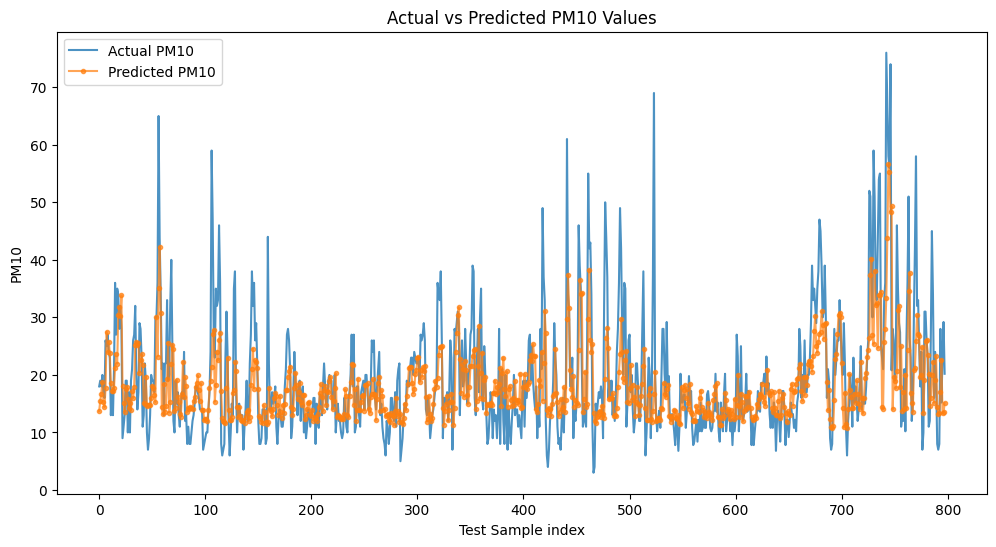

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual PM10', alpha=0.8)
plt.plot(y_pred_actual, label='Predicted PM10', marker='.', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted PM10 Values')
plt.ylabel('PM10')
plt.xlabel('Test Sample index')
plt.show()

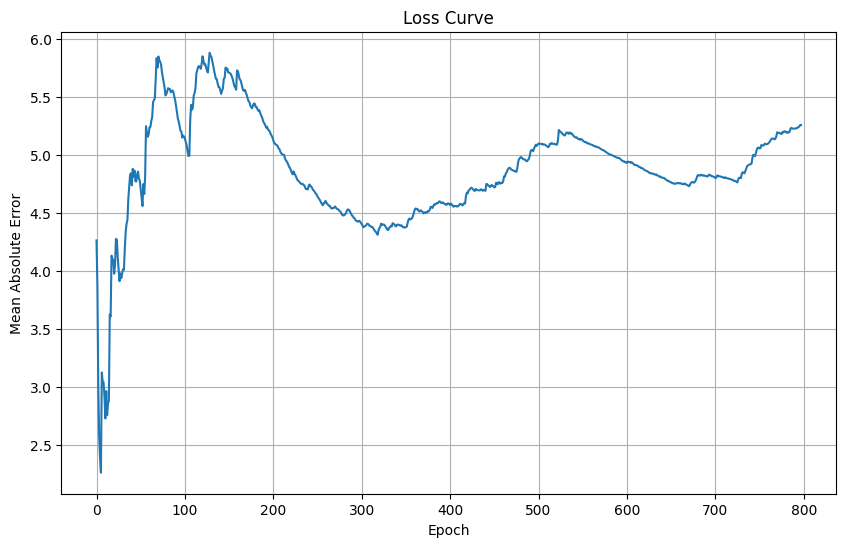

In [21]:
losses = [mean_absolute_error(y_test_actual[:i+1], y_pred_actual[:i+1]) for i in range(len(y_test_actual))]


plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Loss Curve")
plt.grid(True)
plt.show()